# Solving orbital equations with different algorithms

This notebook was adapted from `Orbit_games.ipynb`.



We consider energy plots and orbital solutions in polar coordinates for the general potential energy

$\begin{align}
   U(r) = k r^n
\end{align}$

for different ODE solution algorithms.  The `solve_ivp` function can itself be specified to use different solution methods (with the `method` keyword).  Here we will set it by default to use 'RK23', which is a variant on the Runge-Kutta second-order algorithm.  Second-order in this context means that the accuracy of a calculation will improve by a factor of $10^2 = 100$ if $\Delta t$ is reduced by a factor of ten. 

We will compare it with the crudest algorithm, Euler's method, which is first order, and a second-order algorithm called Leapfrog, which is designed to be precisely <em>time-reversal invariant</em>.  This property guarantees conservation of energy, which is not true of the other algorithms we will consider.

To solve the differential equations for orbits, we have defined the $\mathbf{y}$ 
and $d\mathbf{y}/dt$ vectors as

$\begin{align}
  \mathbf{y} = \left(\begin{array}{c} r(t) \\ \dot r(t) \\ \phi(t)  \end{array} \right) 
  \qquad
  \frac{d\mathbf{y}}{dt} 
       = \left(\begin{array}{c} \dot r(t) \\ \ddot r(t) \\ \dot\phi(t) \end{array} \right) 
       = \left(\begin{array}{c} \dot r(t) \\ 
                                 -\frac{1}{\mu}\frac{dU_{\rm eff}(r)}{dr} \\ 
                                 \frac{l}{\mu r^2} \end{array} \right) 
\end{align}$

where we have substituted the differential equations for $\ddot r$ and $\dot\phi$.

Then Euler's method can be written as a simple prescription to obtain $\mathbf{y}_{i+1}$ 
from $\mathbf{y}_i$, where the subscripts label the elements of the `t_pts` array: 
$\mathbf{y}_{i+1} = \mathbf{y}_i + \left(d\mathbf{y}/dt\right)_i \Delta t$, or, by components:

$\begin{align}
   r_{i+1} &= r_i + \frac{d\mathbf{y}_i[0]}{dt}  \Delta t  \\
   \dot r_{i+1} &= \dot r_{i} + \frac{d\mathbf{y}_i[1]}{dt}  \Delta t \\
   \phi_{i+1} &= \phi_i + \frac{d\mathbf{y}_i[2]}{dt} \Delta t
\end{align}$

**Look at the** `solve_ode_Euler` **method below and verify the algorithm is correctly implemented.** 

The leapfrog method does better by evaluating $\dot r$ at a halfway time step before and after the $r$ evaluation, 
which is both more accurate and incorporates time reversal: 

$\begin{align}
   \dot r_{i+1/2} &= \dot r_{i} + \frac{d\mathbf{y}_i[1]}{dt}  \Delta t/2 \\
   r_{i+1} &= r_i + \frac{d\mathbf{y}_i[0]}{dt}  \Delta t  \\
   \dot r_{i+1} &= \dot r_{i+1/2} + \frac{d\mathbf{y}_{i+1}[1]}{dt}  \Delta t/2 \\
   \phi_{i+1} &= \phi_i + \frac{d\mathbf{y}_i[2]}{dt} \Delta t
\end{align}$

**Look at the** `solve_ode_Leapfrog` **method below and verify the algorithm is correctly implemented.** 

A third method is the second-order Runge-Kutta algorithm, which we invoke from `solve_ivp` as `RK23`. 
It does not use a fixed time-step as in our "homemade" implementations, so there is not a direct 
comparison, but we can still check if it conserves energy.

**Run the notebook.  You are to turn in and comment on the "Change in energy with time" plot at the end.  
Where do you see energy conserved or not conserved?  Show that Euler is first order and leapfrog is second 
order by changing $\Delta t$; describe what you did and what you found.**

**Try another potential to see if you get the same general conclusions.**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

In [4]:
class Orbit:
    """
    Potentials and associated differential equations for central force motion
    with the potential U(r) = k r^n.  Several algorithms for integration of 
    ordinary differential equations are now available. 
    """
    
    def __init__(self, ang_mom, n, k=1, mu=1):
        self.ang_mom = ang_mom
        self.n = n
        self.k = k
        self.mu = mu
    
    def U(self, r):
        """Potential energy of the form U = kr^n."""
        return self.k * r**self.n
    
    def Ucf(self, r):
        """Centrifugal potential energy"""
        return self.ang_mom**2 / (2. * self.mu * r**2)
    
    def Ueff(self, r):
        """Effective potential energy"""
        return self.U(r) + self.Ucf(r)
    
    def U_deriv(self, r):
        """dU/dr"""
        return self.n * self.k * r**(self.n - 1)
        
    def Ucf_deriv(self, r):
        """dU_cf/dr"""
        return -2. * self.ang_mom**2 / (2. * self.mu * r**3)
        
    def Ueff_deriv(self, r):
        """dU_eff/dr"""
        return self.U_deriv(r) + self.Ucf_deriv(r)
        
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dr/dt d^2r/dt^2 dphi/dt]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            3-component vector with y[0] = r(t), y[1] = dr/dt, y[2] = phi
            
        """
        return [ y[1], 
                -1./self.mu * self.Ueff_deriv(y[0]), 
                self.ang_mom / (self.mu * y[0]**2) ]
    
    
    def solve_ode(self, t_pts, r_0, r_dot_0, phi_0,
                  method='RK23',
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions.
        Use solve_ivp with the option of specifying the method.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [r_0, r_dot_0, phi_0]  
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, method=method, 
                             atol=abserr, rtol=relerr)
        r, r_dot, phi = solution.y
        return r, r_dot, phi
    
    def solve_ode_Euler(self, t_pts, r_0, r_dot_0, phi_0):
        """
        Solve the ODE given initial conditions with the Euler method.
        The accuracy is determined by the spacing of times in t_pts.
        """
        
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for r, rdot, phi with zeros
        num_t_pts = len(t_pts)    # length of the array t_pts
        r = np.zeros(num_t_pts)
        r_dot = np.zeros(num_t_pts)
        phi = np.zeros(num_t_pts)
        
        # initial conditions
        r[0] = r_0
        r_dot[0] = r_dot_0
        phi[0] = phi_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            y = [r[i], r_dot[i], phi[i]]
            r[i+1] = r[i] + self.dy_dt(t,y)[0] * delta_t
            r_dot[i+1] = r_dot[i] + self.dy_dt(t,y)[1] * delta_t 
            phi[i+1] = phi[i] + self.dy_dt(t,y)[2] * delta_t
        return r, r_dot, phi   
    
    
    def solve_ode_Leapfrog(self, t_pts, r_0, r_dot_0, phi_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for r, rdot, r_dot_half, phi with zeros
        num_t_pts = len(t_pts)
        r = np.zeros(num_t_pts)
        r_dot = np.zeros(num_t_pts)
        r_dot_half = np.zeros(num_t_pts)
        phi = np.zeros(num_t_pts)
        
        # initial conditions
        r[0] = r_0
        r_dot[0] = r_dot_0
        phi[0] = phi_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            y = [r[i], r_dot[i], phi[i]]
            r_dot_half[i] = r_dot[i] + self.dy_dt(t, y)[1] * delta_t/2.
            r[i+1] = r[i] + r_dot_half[i] * delta_t
            
            y = [r[i+1], r_dot[i], phi[i]]
            r_dot[i+1] = r_dot_half[i] + self.dy_dt(t, y)[1] * delta_t/2.
            
            phi[i+1] = phi[i] + self.dy_dt(t,y)[2] * delta_t
        return r, r_dot, phi   
        
    
    def energy(self, t_pts, r, r_dot):
        """Evaluate the energy as a function of time"""
        return (self.mu/2.) * r_dot**2 + self.Ueff(r)

In [5]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

# Pick a potential

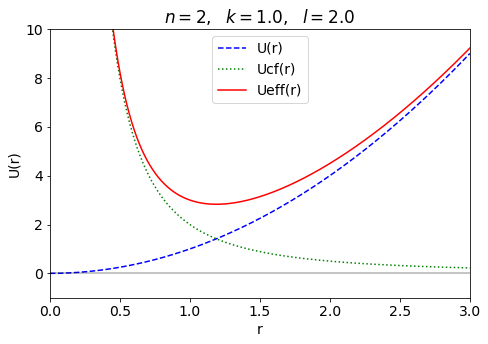

In [6]:
n = 2  
k = 1. 
ang_mom = 2. 
o1 = Orbit(ang_mom, n=n, k=k, mu=1)

fig_2 = plt.figure(figsize=(7,5))
ax_2 = fig_2.add_subplot(1,1,1)

r_pts = np.linspace(0.001, 3., 2000)
U_pts = o1.U(r_pts)
Ucf_pts = o1.Ucf(r_pts)
Ueff_pts = o1.Ueff(r_pts)

ax_2.plot(r_pts, U_pts, linestyle='dashed', color='blue', label='U(r)')
ax_2.plot(r_pts, Ucf_pts, linestyle='dotted', color='green', label='Ucf(r)')
ax_2.plot(r_pts, Ueff_pts, linestyle='solid', color='red', label='Ueff(r)')

ax_2.set_xlim(0., 3.)
ax_2.set_ylim(-1., 10.)
ax_2.set_xlabel('r')
ax_2.set_ylabel('U(r)')
ax_2.set_title(f'$n = {n},\ \ k = {k},\ \  l = {ang_mom}$')
ax_2.legend(loc='upper center')

ax_2.axhline(0., color='black', alpha=0.3)


fig_2.tight_layout()

#fig_2.savefig('Gravitation_orbit_1.png')


## Plot orbit and check energy conservation

In [7]:
# Plotting time 
t_start = 0.
t_end = 10.
delta_t1 = 0.001
delta_t2 = .0001

t_pts = np.arange(t_start, t_end+delta_t1, delta_t1)  
t_pts2 = np.arange(t_start, t_end+delta_t2, delta_t2)

# Initial conditions
r_0 = 1.  #  1.
r_dot_0 = 0.
phi_0 = 0.0
r_pts, r_dot_pts, phi_pts = o1.solve_ode(t_pts, r_0, r_dot_0, phi_0)
r_pts_Euler, r_dot_pts_Euler, phi_pts_Euler \
                              = o1.solve_ode_Euler(t_pts, r_0, r_dot_0, phi_0)

r_pts_LF, r_dot_pts_LF, phi_pts_LF \
                           = o1.solve_ode_Leapfrog(t_pts, r_0, r_dot_0, phi_0)

r_pts2, r_dot_pts2, phi_pts2 = o1.solve_ode(t_pts2, r_0, r_dot_0, phi_0)
r_pts_Euler2, r_dot_pts_Euler2, phi_pts_Euler2 \
                              = o1.solve_ode_Euler(t_pts2, r_0, r_dot_0, phi_0)
r_pts_LF2, r_dot_pts_LF2, phi_pts_LF2 \
                           = o1.solve_ode_Leapfrog(t_pts2, r_0, r_dot_0, phi_0)

c = o1.ang_mom**2 / (np.abs(o1.k) * o1.mu)
epsilon = c / r_0 - 1.
energy_0 = o1.mu/2. * r_dot_0**2 + o1.Ueff(r_0)
print(f'energy = {energy_0:.2f}')
print(f'eccentricity = {epsilon:.2f}')

print(len(r_pts))
print(len(t_pts))

energy = 3.00
eccentricity = 3.00
10001
10001


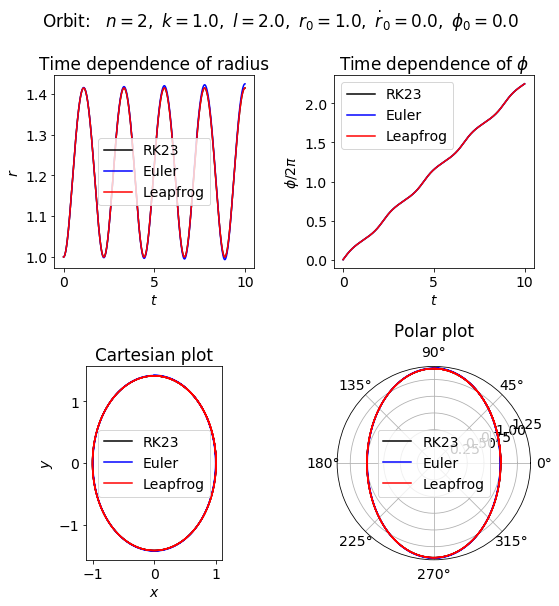

In [10]:
fig_4 = plt.figure(figsize=(8,8))

overall_title = 'Orbit:  ' + \
                rf' $n = {o1.n},$' + \
                rf' $k = {o1.k:.1f},$' + \
                rf' $l = {o1.ang_mom:.1f},$' + \
                rf' $r_0 = {r_0:.1f},$' + \
                rf' $\dot r_0 = {r_dot_0:.1f},$' + \
                rf' $\phi_0 = {phi_0:.1f}$' + \
                '\n'     # \n means a new line (adds some space here)
fig_4.suptitle(overall_title, va='baseline')

ax_4a = fig_4.add_subplot(2,2,1)
ax_4a.plot(t_pts, r_pts, color='black', label='RK23')
ax_4a.plot(t_pts, r_pts_Euler, color='blue', label='Euler')
ax_4a.plot(t_pts, r_pts_LF, color='red', label='Leapfrog')
ax_4a.set_xlabel(r'$t$')
ax_4a.set_ylabel(r'$r$')
ax_4a.set_title('Time dependence of radius')
ax_4a.legend()

ax_4b = fig_4.add_subplot(2,2,2)
ax_4b.plot(t_pts, phi_pts/(2.*np.pi), color='black', label='RK23')
ax_4b.plot(t_pts, phi_pts_Euler/(2.*np.pi), color='blue', label='Euler')
ax_4b.plot(t_pts, phi_pts_LF/(2.*np.pi), color='red', label='Leapfrog')
ax_4b.set_xlabel(r'$t$')
ax_4b.set_ylabel(r'$\phi/2\pi$')
ax_4b.set_title(r'Time dependence of $\phi$')
ax_4b.legend()

ax_4c = fig_4.add_subplot(2,2,3)
ax_4c.plot(r_pts*np.cos(phi_pts), r_pts*np.sin(phi_pts), 
           color='black', label='RK23')
ax_4c.plot(r_pts_Euler*np.cos(phi_pts_Euler), 
           r_pts_Euler*np.sin(phi_pts_Euler), 
           color='blue', label='Euler')
ax_4c.plot(r_pts_LF*np.cos(phi_pts_LF), 
           r_pts_LF*np.sin(phi_pts_LF), 
           color='red', label='Leapfrog')
ax_4c.set_xlabel(r'$x$')
ax_4c.set_ylabel(r'$y$')
ax_4c.set_aspect('equal')
ax_4c.set_title('Cartesian plot')
ax_4c.legend()

ax_4d = fig_4.add_subplot(2,2,4, polar=True)
ax_4d.plot(phi_pts, r_pts, color='black', label='RK23')
ax_4d.plot(phi_pts_Euler, r_pts_Euler, color='blue', label='Euler')
ax_4d.plot(phi_pts_LF, r_pts_LF, color='red', label='Leapfrog')
ax_4d.set_title('Polar plot', pad=20.)
ax_4d.legend()


fig_4.tight_layout()



In [20]:
E_tot_pts = o1.energy(t_pts, r_pts, r_dot_pts)
E_tot_0 = E_tot_pts[0]
E_tot_rel_pts = np.abs((E_tot_pts - E_tot_0)/E_tot_0)

E_tot_pts_Euler = o1.energy(t_pts, r_pts_Euler, r_dot_pts_Euler)
E_tot_0_Euler = E_tot_pts_Euler[0]
E_tot_rel_pts_Euler = np.abs((E_tot_pts_Euler - E_tot_0_Euler)/E_tot_0_Euler)

E_tot_pts_LF = o1.energy(t_pts, r_pts_LF, r_dot_pts_LF)
E_tot_0_LF = E_tot_pts_LF[0]
E_tot_rel_pts_LF = np.abs((E_tot_pts_LF - E_tot_0_LF)/E_tot_0_LF)

E_tot_pts2 = o1.energy(t_pts2, r_pts2, r_dot_pts2)
E_tot_02 = E_tot_pts2[0]
E_tot_rel_pts2 = np.abs((E_tot_pts2 - E_tot_02)/E_tot_02)

E_tot_pts_Euler2 = o1.energy(t_pts2, r_pts_Euler2, r_dot_pts_Euler2)
E_tot_0_Euler2 = E_tot_pts_Euler2[0]
E_tot_rel_pts_Euler2 = np.abs((E_tot_pts_Euler2 - E_tot_0_Euler2)/E_tot_0_Euler2)

E_tot_pts_LF2 = o1.energy(t_pts2, r_pts_LF2, r_dot_pts_LF2)
E_tot_0_LF2 = E_tot_pts_LF2[0]
E_tot_rel_pts_LF2 = np.abs((E_tot_pts_LF2 - E_tot_0_LF2)/E_tot_0_LF2)


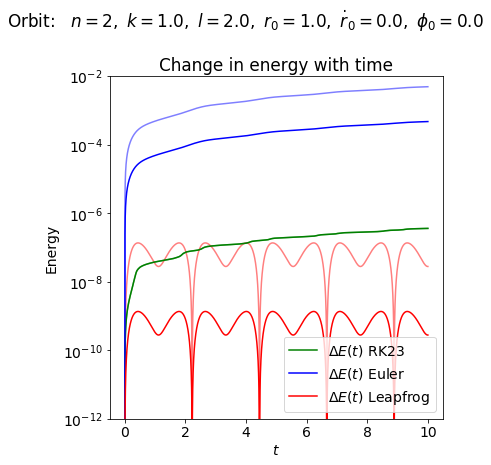

In [22]:
fig_5 = plt.figure(figsize=(6,6))

overall_title = 'Orbit:  ' + \
                rf' $n = {o1.n},$' + \
                rf' $k = {o1.k:.1f},$' + \
                rf' $l = {o1.ang_mom:.1f},$' + \
                rf' $r_0 = {r_0:.1f},$' + \
                rf' $\dot r_0 = {r_dot_0:.1f},$' + \
                rf' $\phi_0 = {phi_0:.1f}$' + \
                '\n'     # \n means a new line (adds some space here)
fig_5.suptitle(overall_title, va='baseline')

ax_5a = fig_5.add_subplot(1,1,1)
#ax_5a.semilogy(t_pts, np.abs(E_tot_pts), color='black', label=r'$E(t)$')
ax_5a.semilogy(t_pts, E_tot_rel_pts, 
               color='green', alpha=0.5)
ax_5a.semilogy(t_pts, E_tot_rel_pts_Euler, 
               color='blue', alpha=0.5)
ax_5a.semilogy(t_pts, E_tot_rel_pts_LF, 
               color='red', alpha=0.5)

ax_5a.semilogy(t_pts2, E_tot_rel_pts2, 
               color='green', label=r'$\Delta E(t)$ RK23')
ax_5a.semilogy(t_pts2, E_tot_rel_pts_Euler2, 
               color='blue', label=r'$\Delta E(t)$ Euler')
ax_5a.semilogy(t_pts2, E_tot_rel_pts_LF2, 
               color='red', label=r'$\Delta E(t)$ Leapfrog')

ax_5a.set_ylim(1.e-12, 1.e-2)    # (1.e-12, 5)
ax_5a.set_xlabel(r'$t$')
ax_5a.set_ylabel(r'Energy')
ax_5a.set_title('Change in energy with time')
ax_5a.legend()

fig_5.tight_layout()
fig_5.savefig('Leapfrog_energy_test_1.png', dpi=200)
